In [6]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split

from skimage.util import montage as montage2d
from conv import ConvRNN2D, ConvFF2DCell, ConvFF2D

In [2]:
all_images=glob(os.path.join(r"D:\Spring_2023\Statistical Machine Learning\3d_data\archive",'3d_images','IMG_*'))


In [3]:
DS_FACT = 8 # downscale
def read_all_slices(in_paths, rescale = True):
    cur_vol = np.expand_dims(np.concatenate([nib.load(c_path).get_fdata()[:, ::DS_FACT, ::DS_FACT] 
                                          for c_path in in_paths], 0), -1)
    if rescale:
        return (cur_vol.astype(np.float32) + 500)/2000.0
    else:
        return cur_vol/255.0
    
    
def read_both(in_paths):
    in_vol = read_all_slices(in_paths)
    in_mask = read_all_slices(map(lambda x: x.replace('IMG_', 'MASK_'), in_paths), rescale = False)
    return in_vol, in_mask


def montage_nd(in_img):
    if len(in_img.shape)>3:
        return montage2d(np.stack([montage_nd(x_slice) for x_slice in in_img],0))
    elif len(in_img.shape)==3:
        return montage2d(in_img)
    else:
        warn('Input less than 3d image, returning original', RuntimeWarning)
        return in_img

In [7]:
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D
from keras.models import Sequential
sim_model = Sequential()
sim_model.add(BatchNormalization(input_shape = (None, None, None, 1)))
sim_model.add(Conv3D(8, 
                     kernel_size = (1, 5, 5), 
                     padding = 'same',
                     activation = 'relu'))
sim_model.add(Conv3D(8, 
                     kernel_size = (3, 3, 3), 
                     padding = 'same',
                     activation = 'relu'))
sim_model.add(BatchNormalization())
sim_model.add(Bidirectional(ConvFF2D(16, 
                                       kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True)))
sim_model.add(Bidirectional(ConvFF2D(32, 
                                       kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True)))
sim_model.add(Conv3D(8, 
                     kernel_size = (1, 3, 3), 
                     padding = 'same',
                     activation = 'relu'))
sim_model.add(Conv3D(1, 
                     kernel_size = (1,1,1), 
                     activation = 'sigmoid'))
sim_model.add(Cropping3D((1, 2, 2))) # avoid skewing boundaries
sim_model.add(ZeroPadding3D((1, 2, 2)))
sim_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, None, None, None,  4         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, None, None, None,  208       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, None, None, None,  1736      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, None,  32        
_________________________________________________________________
bidirectional (Bidirectional (None, None, None, None,  13888     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, None, None,  73856     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, None, None, None, 

In [63]:
from keras.models import model_from_json

# Assuming your Keras model is named 'model'
model_json = sim_model.to_json()

# Save the model architecture to file
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

In [8]:
sim_model.load_weights('convlstm_model_weights.best.hdf5')


In [10]:
train_paths, test_paths = train_test_split(all_images, random_state = 2018, test_size = 0.5)


In [11]:
test_single_vol, test_single_mask = read_both(test_paths[0:1])


In [28]:
pred_seg = sim_model.predict(np.expand_dims(test_single_vol,0))


In [60]:
np.expand_dims(test_single_vol,0).shape

(1, 465, 64, 64, 1)

In [62]:
np.save('prediction_array.npy', np.expand_dims(test_single_vol,0))


In [56]:
# (np.expand_dims(test_single_vol,0)[0][150])

In [44]:
# plt.imshow(pred_seg[0][210])
pred_seg = pred_seg[0]

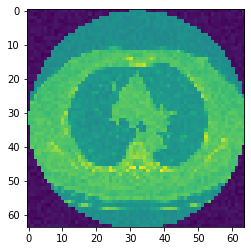

In [26]:
plt.imshow(np.expand_dims(test_single_vol,0)[0][280])

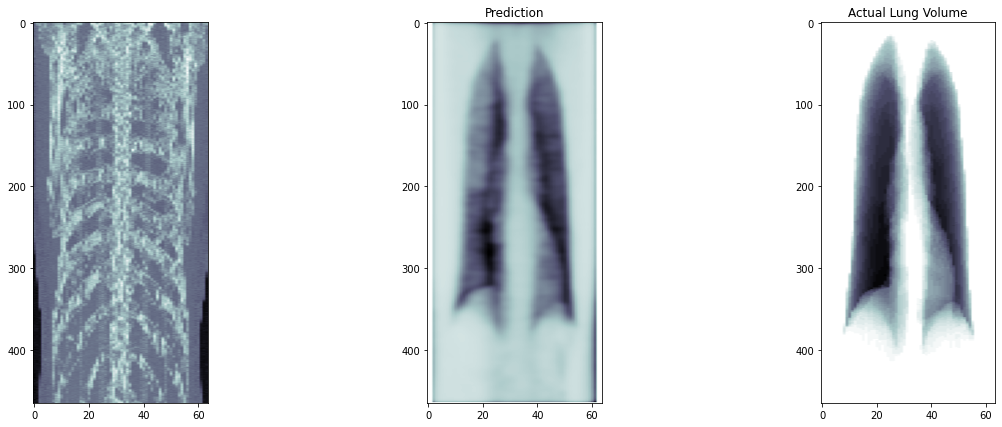

In [45]:
from skimage.util import montage as montage2d
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(np.max(test_single_vol[::-1, :, :, 0], 1), cmap = 'bone')
ax1.set_aspect(0.3)
ax2.imshow(np.sum(pred_seg[::-1, :, :, 0], 1), cmap = 'bone_r')
ax2.set_title('Prediction')
ax2.set_aspect(0.3)
ax3.imshow(np.sum(test_single_mask[::-1, :, :, 0], 1), cmap = 'bone_r')
ax3.set_title('Actual Lung Volume')
ax3.set_aspect(0.3)
fig.savefig('full_scan_prediction.png', dpi = 300)